In [2]:
pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 18.3 MB/s eta 0:00:00


In [49]:
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
import datetime
import  time
from arch import arch_model
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error
import warnings
import scipy.optimize as optimize



In [19]:
stocks = '^GSPC'
start = datetime.datetime(2023, 5, 26)
end = datetime.datetime(2023, 8, 20)
s_p0 = yf.download(stocks, start=start, end = end, interval='1d' )

[*********************100%***********************]  1 of 1 completed


In [20]:
ret = 100 * (s_p0.pct_change()[1:]['Adj Close'])
realized_vol = ret.rolling(5).std()

In [21]:
retv = ret.values


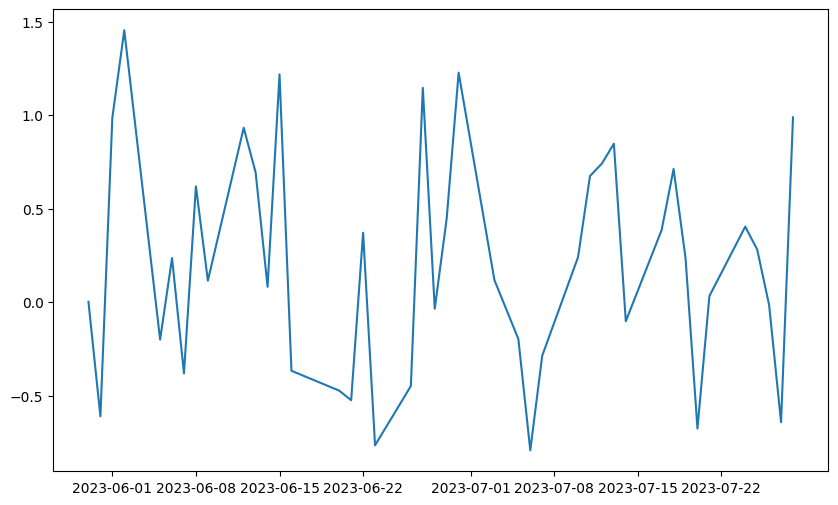

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(s_p0.index[1:], ret)

# ARCH *MODEL*







In [23]:
# Defining the split location and assign the splitted data to split variable
# Calculating variance of GSPC

n= 252
split_date = ret.iloc[-n:].index

In [24]:
# Calculating kurtois of GSPC
# Indetifying the initial value for slope coefficient



sgm2 = ret.var()
k = ret.kurtosis()
alpha = (-3.0 * sgm2 + np.sqrt(9.0 * sgm2 ** 2 - 12.0 *(3.0 * sgm2 - k ) *k)) / (6 * k)

omega = ( 1 - alpha ) * sgm2
initial_parameters = [alpha, omega]
omega,alpha

(0.6189215991785921, -0.6832734451573345)

In [25]:
@jit(nopython=True, parallel =True)
def arch_likelihood(initial_parameters, retv):
    omega = abs(initial_parameters[0])
    alpha = abs(initial_parameters[1])
    T = len(retv)
    logliks = 0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2[t] = omega + alpha * (retv[t - 1]) ** 2
    logliks = np.sum(0.5 * (np.log(sigma2)+retv ** 2 / sigma2))
    return logliks





In [26]:
logliks = arch_likelihood(initial_parameters, retv)
logliks

/usr/local/lib/python3.10/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'initial_parameters' of function 'arch_likelihood'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-25-f8c9ed1800b9>", line 2:
@jit(nopython=True, parallel =True)
def arch_likelihood(initial_parameters, retv):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


7.035596490484349

In [ ]:
def opt_params(x0, retv):
  opt_result = opt.minimize(arch_likelihood, x0=x0, args = (retv), method = 'Nelder-Mead', options={'maxiter': 5000})
  params = opt_result.x
  print('\nResults of Nelder-Mead minimization\n{}\n{}'.format(''.join(['-'] * 28),opt_result))
  print('\nResulting params = {}'.format(params))
  return params


In [ ]:
params = opt_params(initial_parameters, retv)


Results of Nelder-Mead minimization
----------------------------
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.7740740509709405
             x: [-4.113e-01 -3.376e-07]
           nit: 52
          nfev: 96
 final_simplex: (array([[-4.113e-01, -3.376e-07],
                       [-4.113e-01,  1.228e-06],
                       [-4.114e-01,  1.101e-06]]), array([ 1.774e+00,  1.774e+00,  1.774e+00]))

Resulting params = [-4.11347541e-01 -3.37564377e-07]


In [ ]:
def arch_apply(ret):
    omega = params[0]
    alpha = params[1]
    T = len(ret)
    sigma2_arch = np.zeros(T + 1)
    sigma2_arch[0] = np.var(ret)
    for t in range(1, T):
        sigma2_arch[t] = omega + alpha * ret[t - 1] ** 2
    return sigma2_arch

In [ ]:
sigma2_arch = arch_apply(ret)

In [ ]:
arch = arch_model(ret, mean="zero", vol='ARCH', p=1).fit(disp='off')
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.024
Vol Model:                       ARCH   Log-Likelihood:               -40.4315
Distribution:                  Normal   AIC:                           84.8630
Method:            Maximum Likelihood   BIC:                           88.3384
                                        No. Observations:                   42
Date:                Sat, Jul 29 2023   Df Residuals:                       42
Time:                        15:20:51   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4015      1.080      0.372      0.710 [ -1.716,  2.51

In [ ]:
bic_arch = []

for p in range(1, 5):
     arch = arch_model(ret, mean='zero', vol='ARCH', p=p)\
             .fit(disp='off')
     bic_arch.append(arch.bic)
     if arch.bic == np.min(bic_arch):
          best_params = p
arch = arch_model(ret, mean='Constant', vol='ARCH', p=p)\
       .fit(disp='off')
print(arch.summary())
forecast = arch.forecast(start=split_date[0])
forecast_arch = forecast



                      Constant Mean - ARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -37.9873
Distribution:                  Normal   AIC:                           87.9747
Method:            Maximum Likelihood   BIC:                           98.4007
                                        No. Observations:                   42
Date:                Sat, Jul 29 2023   Df Residuals:                       41
Time:                        15:20:55   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.2034      0.138      1.470      0.142 [-6.78

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [ ]:
n = 40
realized_vol_float = np.array(realized_vol[-n:], dtype=float) / 100
forecast_variance_float = np.array(forecast_arch.variance.iloc[-len(split_date):], dtype=float) / 100
realized_vol_float = np.nan_to_num(realized_vol_float, nan=0.0)
forecast_variance_float = np.nan_to_num(forecast_variance_float, nan=0.0)
rsme_arch = np.sqrt(mean_squared_error(realized_vol_float, np.sqrt(forecast_variance_float)))


In [ ]:
print('The RSME Value of ARCH model is {:.4f}'.format(rsme_arch))

The RSME Value of ARCH model is 0.0543


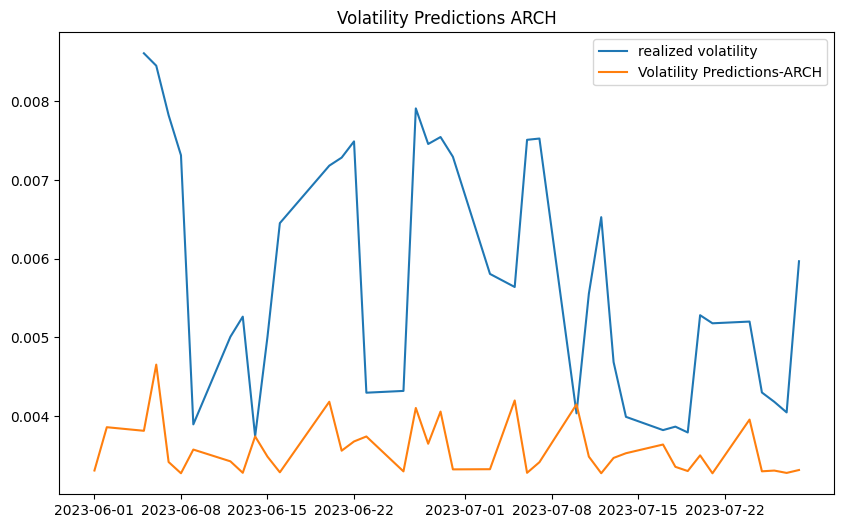

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(realized_vol / 100, label = 'realized volatility')
plt.plot(forecast_arch.variance.iloc[-len(split_date):] / 100, label='Volatility Predictions-ARCH')
plt.title ('Volatility Predictions ARCH', fontsize=12)
plt.legend()
plt.show()

In [30]:
a0 = 0.0001
sgm2 = ret.var()
k = ret.kurtosis()
h = 1 - alpha / sgm2
alpha = np.sqrt(k * (1 - h ** 2) / (2.0 * (k + 3)))
beta = np.abs(h - omega)
omega = (1 - omega) * sgm2
initial_parameters = np.array([omega, alpha, beta])
print('Initial parameters for omega, alpha, and beta are \n{}\n{}\n{}'.format(omega, alpha, beta))

Initial parameters for omega, alpha, and beta are 
0.1401184423881652
1.2121678900462332
2.239368768358947


In [31]:
retv = ret.values


In [42]:
@jit(nopython=True, parallel=True)
def garch_likelihood(initial_parameters, retv):
    omega = initial_parameters[0]
    alpha = initial_parameters[1]
    beta = initial_parameters [2]
    T = len(retv)
    logliks =0
    sigma2 = np.zeros(T)
    sigma2[0] = np.var(retv)
    for t in range(1, T):
        sigma2 [t] = omega +alpha * (retv[t - 1]) ** 2 + beta * sigma2[t-1]
    logliks = np.sum(0.5 * (np.log(sigma2) + retv ** 2 / sigma2))
    return logliks



In [35]:
logliks = garch_likelihood(initial_parameters, retv)
print('The Log Likelihood is {:.4f}'.format(logliks))

The Log Likelihood is 341.2014


In [43]:
def garch_constraint(initial_parameters):
    alpha = initial_parameters[0]
    gamma = initial_parameters[1]
    beta = initial_parameters[2]
    return np.array([1 - alpha - beta])

In [37]:
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

In [79]:
def opt_paramsG(initial_parameters, retv):
    opt_result = opt.minimize(garch_likelihood,
                              x0=initial_parameters,
                              constraints= np.array([1 - alpha - beta]),
                              bounds=bounds, args = (retv),
                              method ='Nelder-Mead',
                              options={'maxiter: 5000'})
    params = opt_result.x


    print('\nResults of Nelder-Mead minimization\n{}\n{}'\
          .format('-' * 35, opt_result))
    print('-' * 35)
    print('\nResulting parameters = {}'.format(params))
    return params
